In [157]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import seaborn as sns


from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression

In [158]:
days = 2**np.arange(0, 11, 1)
days

array([   1,    2,    4,    8,   16,   32,   64,  128,  256,  512, 1024])

In [159]:
train = pd.read_parquet('../data/BTS_new/train.parquet')
test = pd.read_parquet('../data/BTS_new/test.parquet')

In [160]:
test.columns

Index(['ZTFID', 'bts_class', 'objectId', 'jd', 'label', 'fid', 'diffmaglim',
       'programid', 'candid', 'isdiffpos',
       ...
       'ex', 'var', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'qph', 'd2M', '2M',
       'index'],
      dtype='object', length=151)

In [161]:
dataset = pd.concat([train, test])

In [162]:
def plot_ztf_data(ztfid):

    ztf_fid_to_filter = {
        1: 'g',
        2: 'r', 
        3: 'i' 
    }

    ZTF_fid_to_color = {
        'r': np.array((255, 0, 0))/255,
        'g': np.array((0, 255, 0))/255,
        'i': np.array((0, 0, 255))/255,
    }

    im_shape = (63, 63)
    
    row = dataset[dataset['ZTFID']==ztfid]
    
    bts_class = row['bts_class'].to_numpy()
    mag = row['magpsf'].to_numpy()[0]
    mag_unc = row['sigmapsf'].to_numpy()[0]
    time = row['jd'].to_numpy()[0] - min(row['jd'].to_numpy()[0])
    filt = np.array([ztf_fid_to_filter[k] for k in row['fid'].to_numpy()[0]])

    # imgs = {
    #     'g_reference': np.reshape(row['g_reference'].to_numpy()[0], im_shape) if isinstance(row['g_reference'].to_numpy()[0], np.ndarray) else np.zeros(im_shape), 
    #     'r_reference': np.reshape(row['r_reference'].to_numpy()[0], im_shape) if isinstance(row['r_reference'].to_numpy()[0], np.ndarray) else np.zeros(im_shape),
    #     'g_diff': np.reshape(row['g_difference'].to_numpy()[0], im_shape) if isinstance(row['g_science'].to_numpy()[0], np.ndarray) else np.zeros(im_shape), 
    # }
    


    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 1], hspace=0.3, wspace=0.2)
    
    # Top row: light curve across all columns
    ax_lc = fig.add_subplot(gs[0, :])
    for f in np.unique(filt):
        idx = np.where(filt==f)[0]
        ax_lc.errorbar(time[idx], mag[idx], yerr=mag_unc[idx], fmt='o', label=f, color=ZTF_fid_to_color[f])
    plt.legend()
    ax_lc.set_xlabel('Time (days)')
    ax_lc.set_ylabel('mag')
    ax_lc.invert_yaxis()
    
    ax_lc.set_title(f"{ztfid}: {bts_class}")
    
    # # Bottom row: three filter images
    # for i, f in enumerate(imgs.keys()):
    #     ax = fig.add_subplot(gs[1, i])
    #     im = ax.imshow(np.log10(imgs[f]), origin='lower', cmap='viridis')
    #     ax.set_title(f)
    #     ax.axis('off')
    #     # Optional colorbar:
    #     # fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

In [163]:
def get_max_detla_t(ztfids):

    max_deltas = []

    for ztfid in ztfids:
        row = dataset[dataset['ZTFID']==ztfid]
        
        time = row['jd'].to_numpy()[0] 
        delta = time[1:] - time[:-1]
        if len(delta) > 0:
            max_deltas.append(max(delta))
        else:
            max_deltas.append(0)

    
    return max_deltas

        


In [164]:
normal_classes = ['SN-Ia','SN-Ib/c','SN-II','CV','AGN','SLSN']

In [165]:
model_dir = "../models/BTS/lemon-spaceship-252"
ls_dim = 16

In [166]:
final_embeddings = pd.read_csv(f"{model_dir}/embeddings/embeddings+1024.csv")

In [167]:
if_dict = {}
for c in normal_classes:
    class_embeddings = final_embeddings[final_embeddings['class']==c].to_numpy()[:,:ls_dim]
    if_dict[c] = IsolationForest(random_state=0).fit(final_embeddings.to_numpy()[:,:ls_dim])

In [168]:
for d in days:
    scores = []
    day_embeddings = pd.read_csv(f"{model_dir}/embeddings/embeddings+{d}.csv")
    for i in range(len(final_embeddings)):
        class_scores = []
        for c in normal_classes:
            class_scores.append(if_dict[c].decision_function(day_embeddings.to_numpy()[i,:ls_dim].reshape(1, -1)))
        class_scores = -1*np.asarray(class_scores)
        scores.append(min(class_scores)[0])
    final_embeddings[f'a_score_{d}'] = scores

In [169]:
final_embeddings

,0,1,2,3,4,5,6,7,8,9,...,a_score_2,a_score_4,a_score_8,a_score_16,a_score_32,a_score_64,a_score_128,a_score_256,a_score_512,a_score_1024
0,-3.491108,3.937708,0.351305,4.306107,0.574419,-0.450449,2.348690,-3.676456,1.142509,-0.802597,...,-0.008378,-0.058997,0.022153,-0.010212,0.005315,-0.078871,-0.015289,-0.101237,-0.048663,-0.062137
1,-4.025639,6.004972,0.359550,5.350656,1.578800,-0.323333,3.654630,-2.056501,1.766142,-0.460317,...,0.039273,0.014834,-0.102279,0.051064,-0.112876,0.068698,-0.051093,-0.112653,-0.063310,-0.088288
2,4.286979,-1.970967,2.771658,-0.449278,3.039430,-1.453571,-1.203664,1.923113,-0.205398,2.216003,...,-0.024518,-0.025588,0.053975,0.038764,0.039544,-0.054967,0.005750,0.018320,-0.026320,-0.042939
3,-4.025114,3.413968,-2.319533,3.439180,0.024533,-0.628306,3.041064,-0.828245,3.846534,-2.734242,...,-0.022899,0.020990,-0.052619,-0.095780,-0.111942,0.064670,-0.111410,-0.116369,-0.046000,-0.009546
4,-0.137240,1.643509,0.093511,3.174905,0.939044,0.720630,3.279660,-3.314403,4.821916,-2.354475,...,0.002812,0.048661,-0.009302,0.048282,-0.094308,-0.019948,0.015474,-0.041635,-0.038412,0.003084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,-4.797645,6.197208,0.189245,5.540938,1.318758,-0.420857,4.087663,-3.431192,1.489886,-0.526328,...,-0.023738,-0.021709,-0.037816,-0.025300,-0.099153,-0.037077,0.003661,-0.093764,-0.057202,-0.108184
1398,0.199999,1.524002,1.261221,3.291913,3.305106,-1.626090,2.721521,-3.435561,2.330969,-0.165156,...,-0.009844,0.043363,0.032810,0.071948,-0.080671,-0.111266,-0.103072,-0.070088,-0.044718,0.003759
1399,1.853197,0.071650,2.026875,1.633840,3.350235,-1.924091,-0.670591,-0.037156,0.412622,1.467131,...,0.058856,-0.015563,-0.044188,-0.099715,-0.096711,-0.087409,-0.082798,-0.000315,-0.109549,-0.034290
1400,1.838583,-1.163205,0.829176,-0.898923,2.628636,-2.465435,-0.400015,3.072573,-1.320015,2.484960,...,-0.079398,-0.018985,-0.081799,-0.104181,-0.001489,0.008181,-0.015122,-0.001433,0.019232,0.028831


In [173]:
anomalies = final_embeddings.sort_values(by='a_score_1024', ascending=False)[[f'a_score_{d}' for d in days]+['bts_class','ztf_ids','class']]
anomalies_array = anomalies.to_numpy()[:,:11]
slopes = []

for i in range(anomalies_array.shape[0]):
    reg = LinearRegression()
    reg.fit(np.log2(days).reshape(-1, 1), anomalies_array[i, :].reshape(-1, 1))
    m = reg.coef_[0][0]
    slopes.append(m)

anomalies['a_slope'] = slopes
anomalies['time_delta'] = get_max_detla_t(anomalies['ztf_ids'])

anomalies = anomalies[anomalies['time_delta'] < 100]

for c in anomalies['class'].unique():

    a_1024 = anomalies[anomalies['class']==c]['a_score_1024']
    a_slope =anomalies[anomalies['class']==c]['a_slope']

    print(c, np.median(a_1024), np.median(a_slope))

anomalies = anomalies.sort_values(by='a_slope', ascending=False)[['a_slope','bts_class','ztf_ids','class', 'time_delta']].head(n=50)
anomalies    

SLSN 0.0740917247784123 -0.0037966808702674573
CV 0.044834258688298045 -0.0006017475274260553
SN-II 0.0007882647247035024 -0.001111933334266621
SN-Ib/c -0.026622615229598634 -0.003858021821553261
Anomaly -0.018613385006036487 -0.0031260577662906687
SN-Ia -0.08570985934278103 -0.005127459090355091
AGN -0.019525743823790798 -0.002574684120030704


,a_slope,bts_class,ztf_ids,class,time_delta
1158,0.007925,SN II,ZTF22abtomri,SN-II,17.126401
1067,0.007498,SN II,ZTF23aacdlsh,SN-II,19.938669
737,0.006988,SN II-norm,ZTF20acnezne,SN-II,8.018866
808,0.006512,SN Ia-CSM,ZTF20acyroke,Anomaly,19.979444
1030,0.006446,SN II,ZTF22abkkhao,SN-II,50.969421
876,0.006100,SN II,ZTF24abdsgdk,SN-II,15.957037
1083,0.006047,SN Ib,ZTF21abimeun,SN-Ib/c,7.001956
1370,0.005935,SN Ia,ZTF23aajfqti,SN-Ia,9.071713
1098,0.005903,SN Ia,ZTF20acordqz,SN-Ia,8.905347
672,0.005673,SN II,ZTF23aaohfxx,SN-II,4.972083


/var/folders/t6/gdw9ytlx48nd402t7_62k3r00000gn/T/ipykernel_36185/2555156760.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


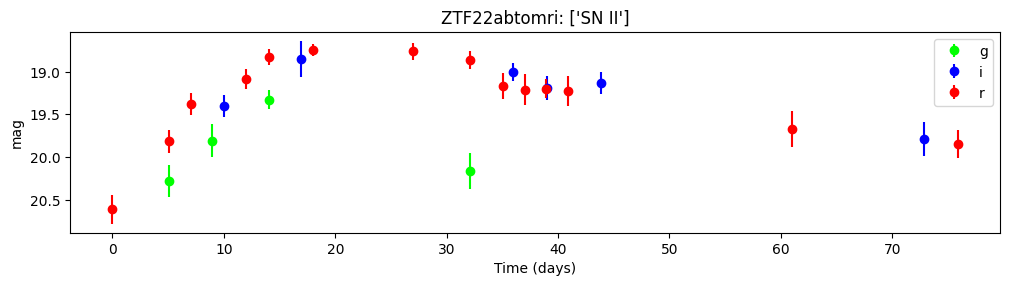

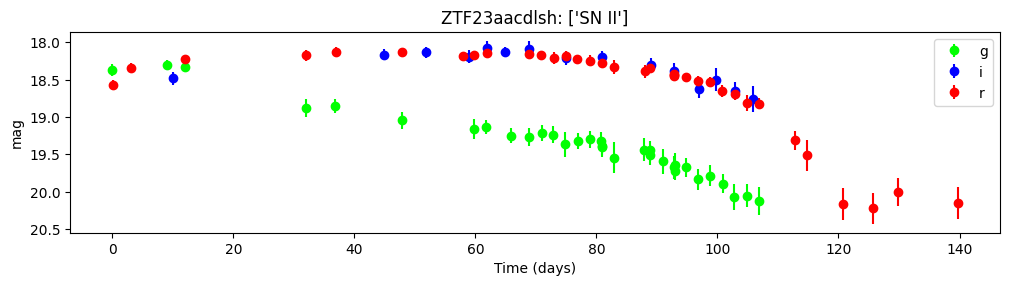

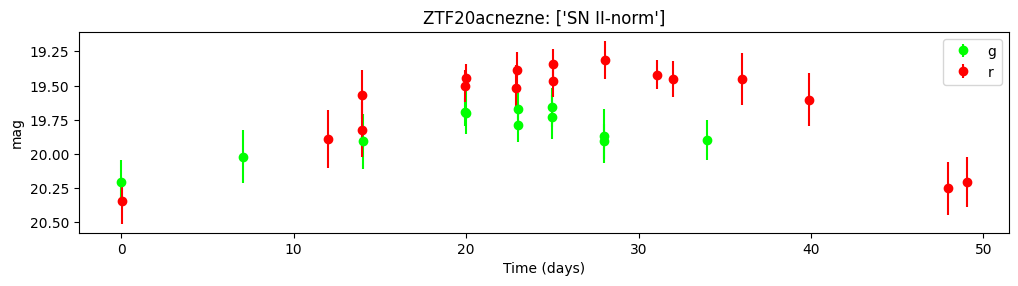

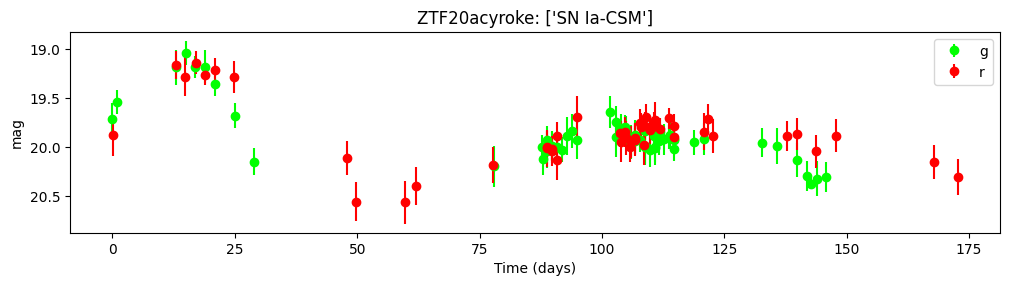

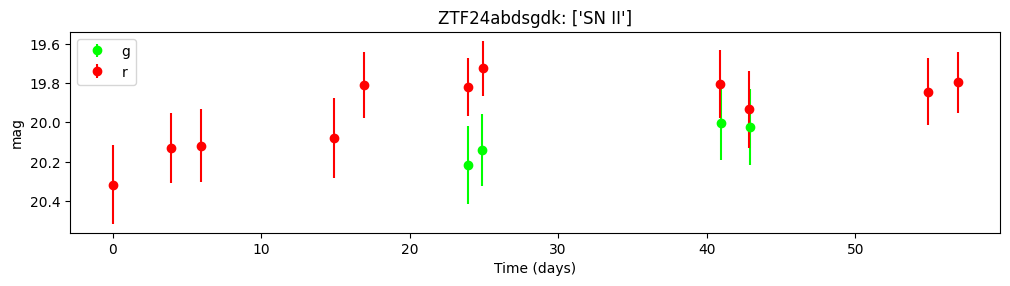

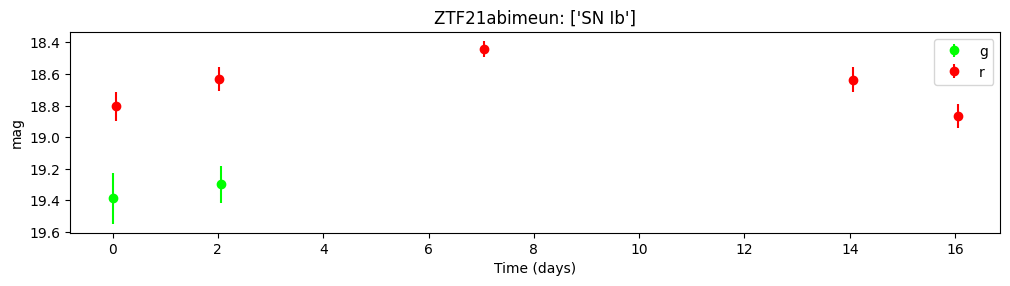

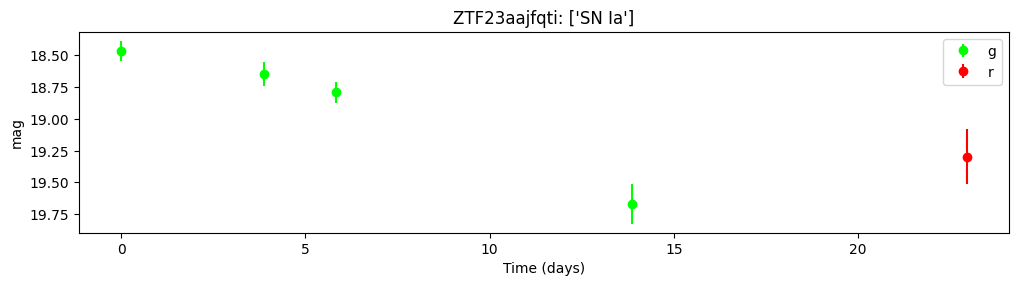

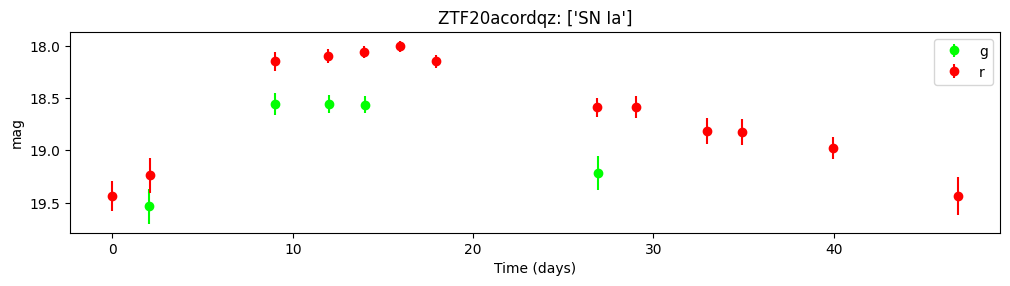

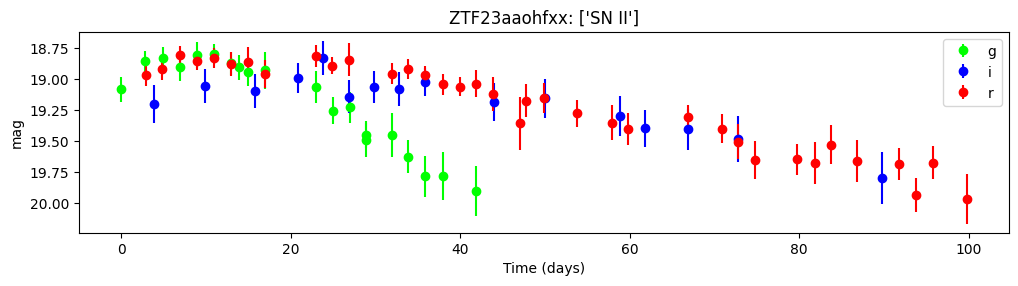

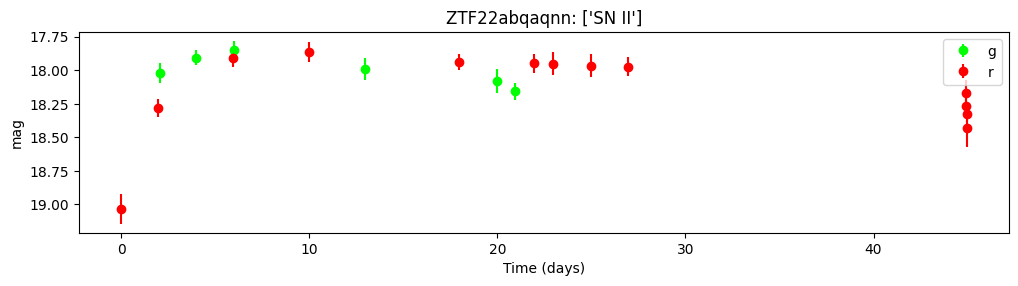

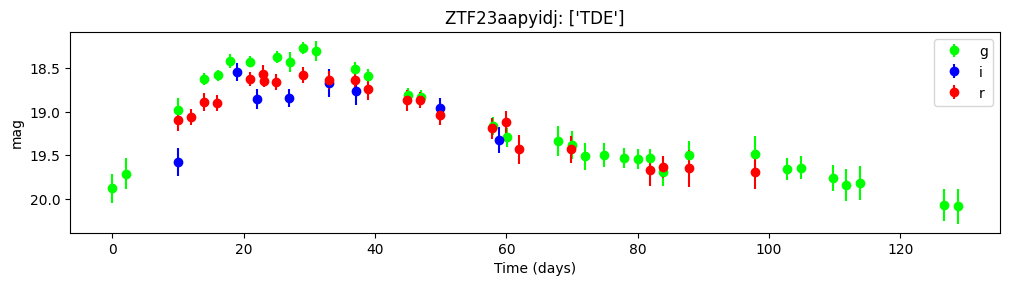

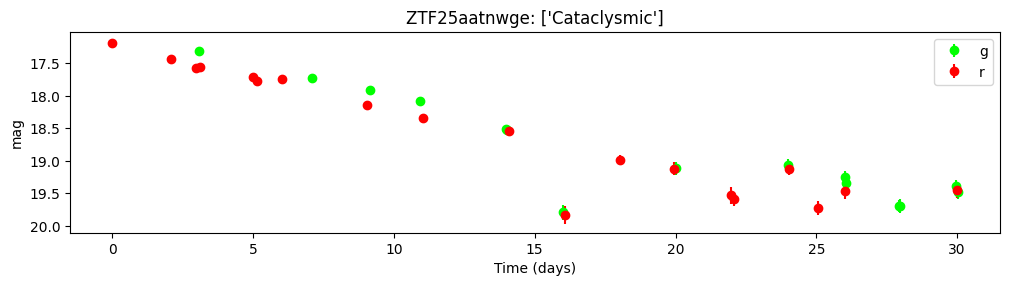

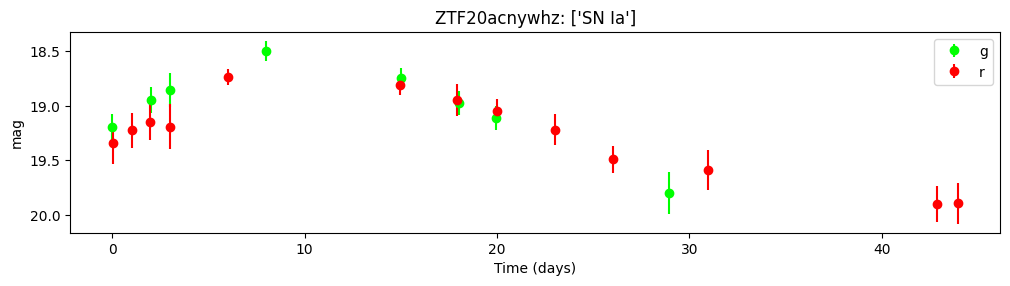

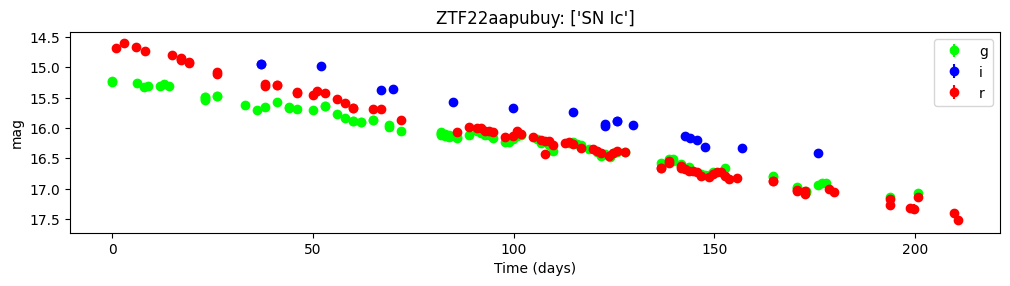

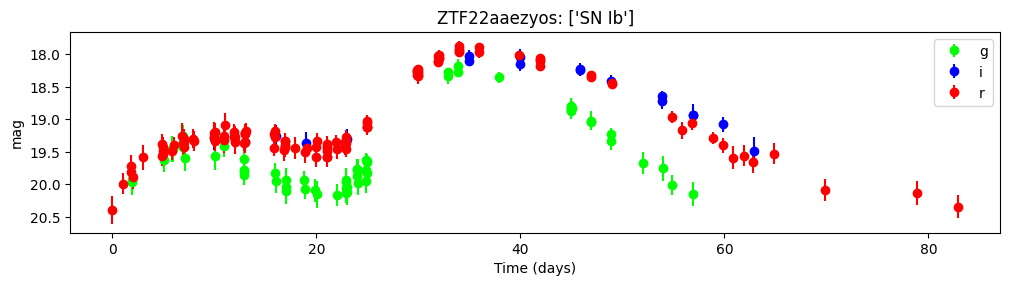

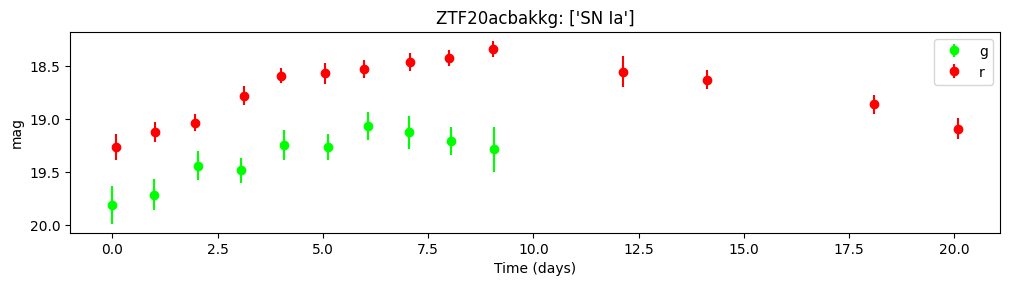

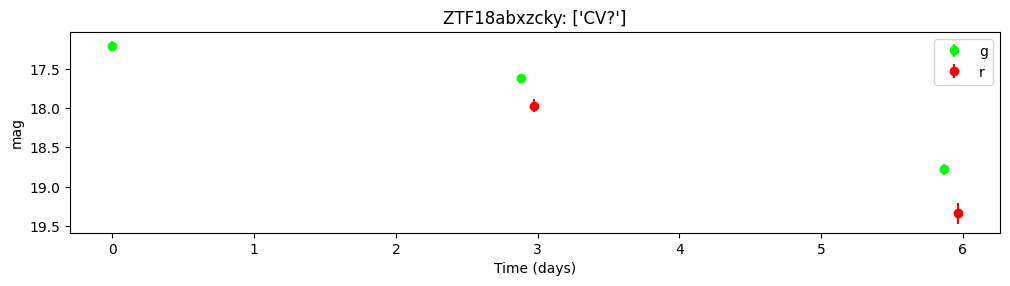

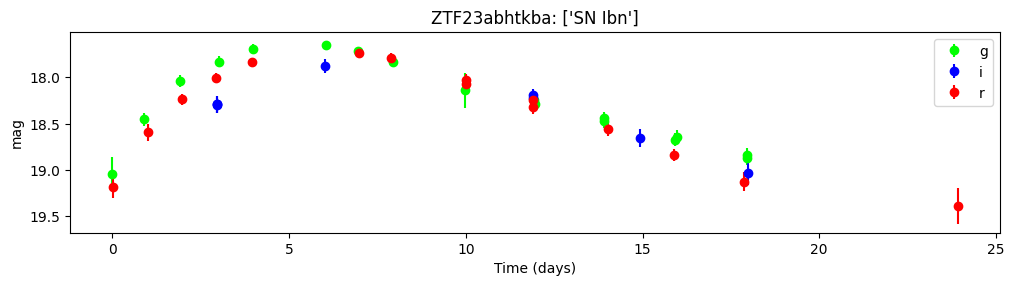

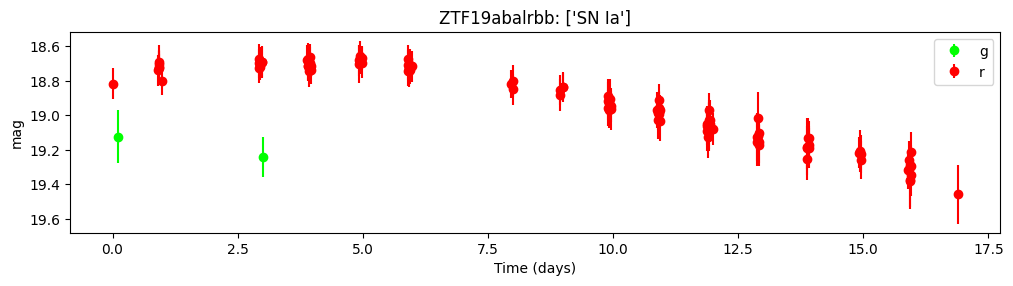

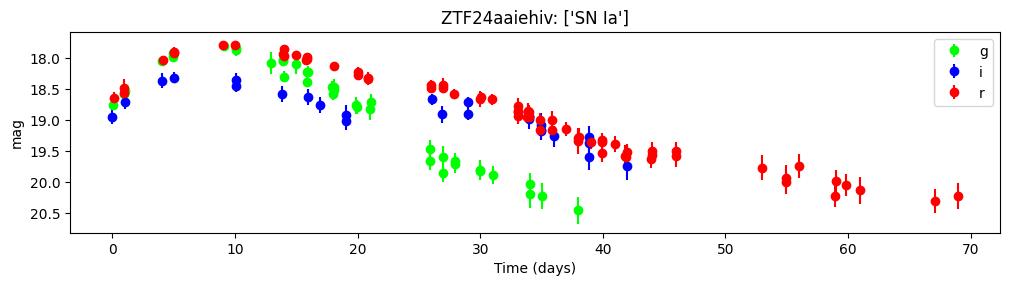

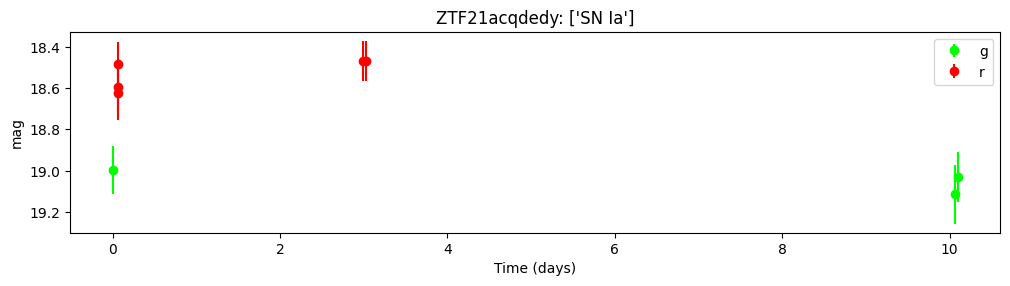

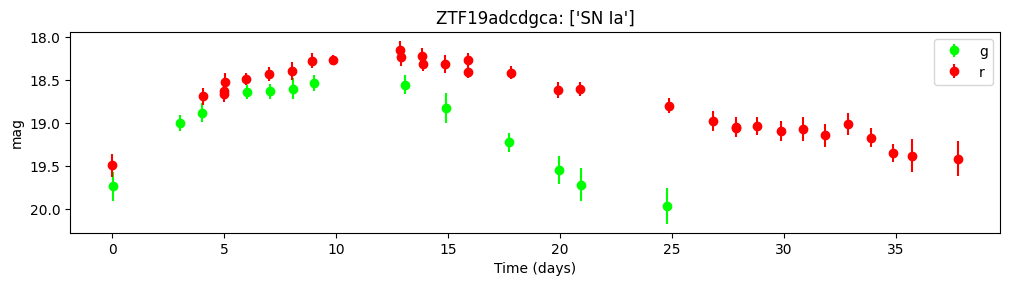

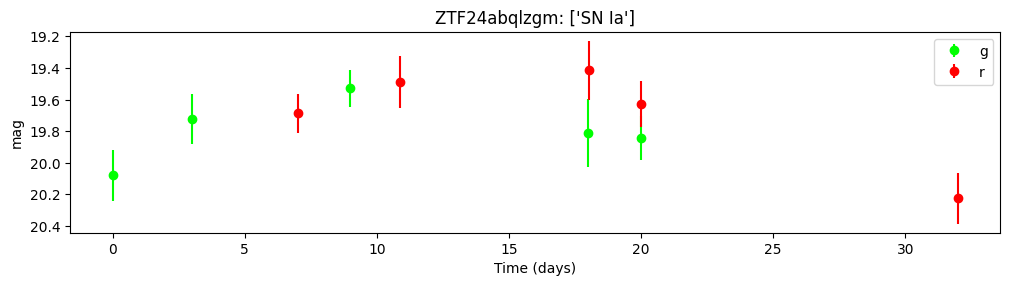

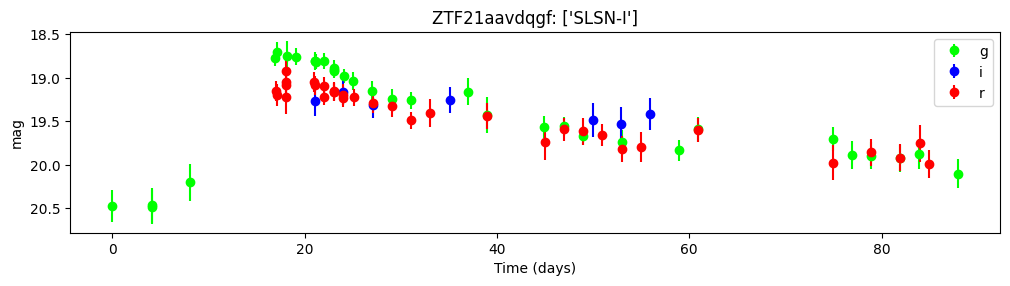

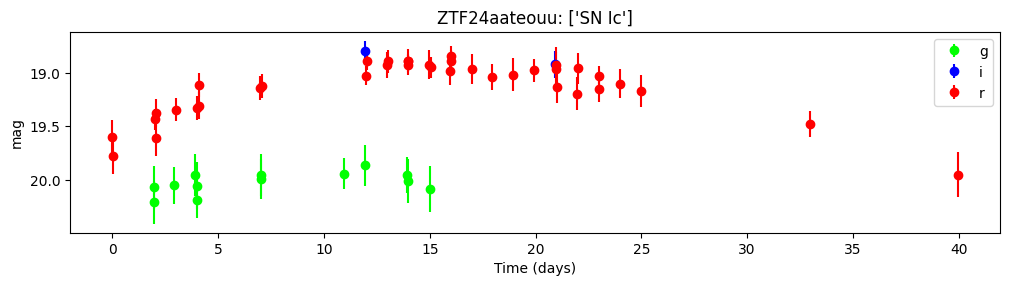

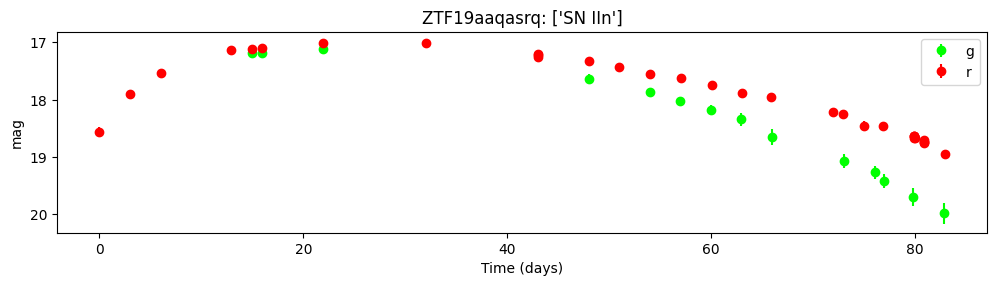

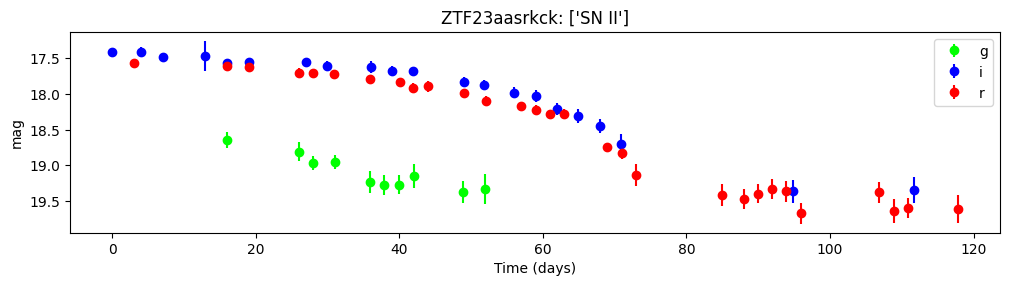

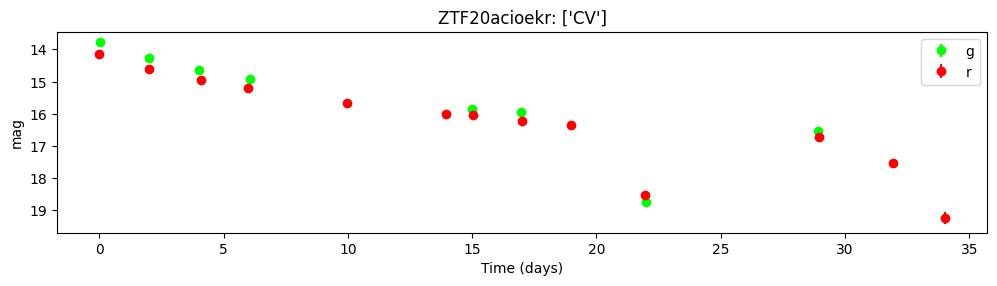

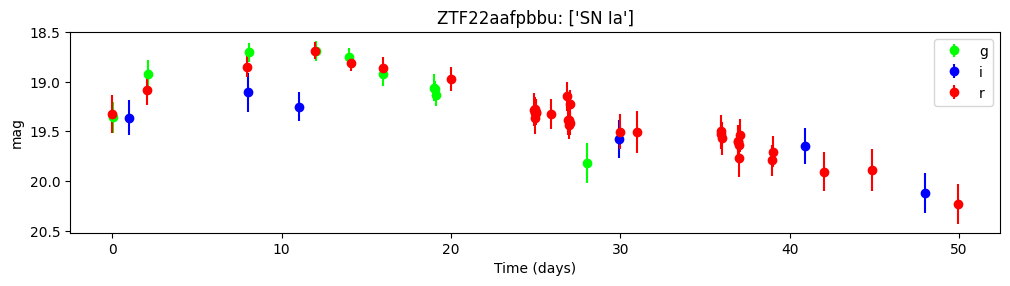

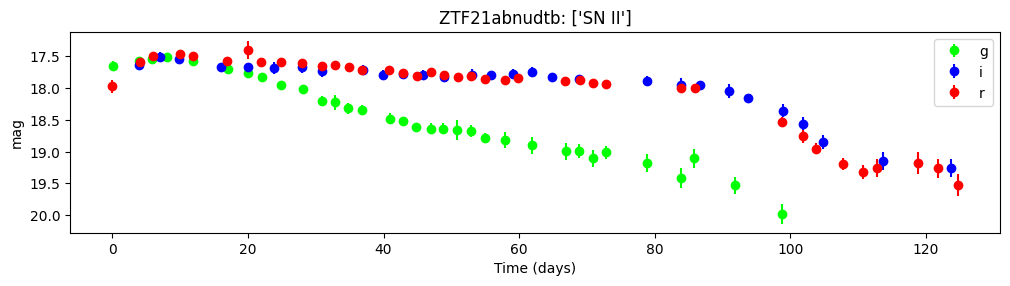

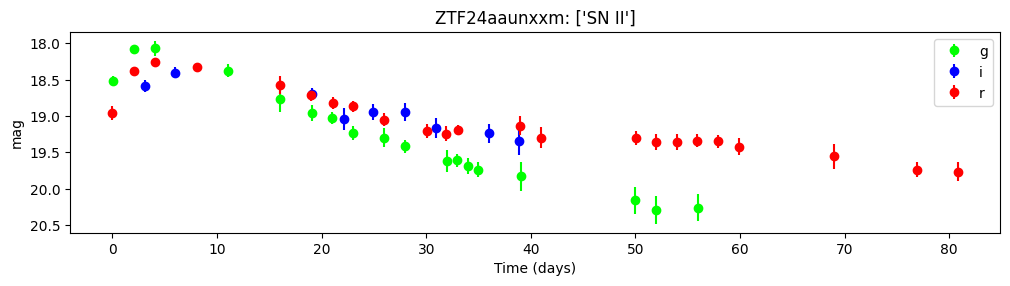

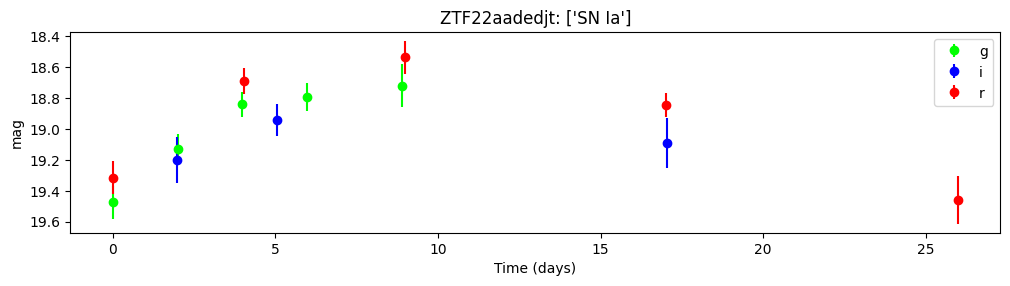

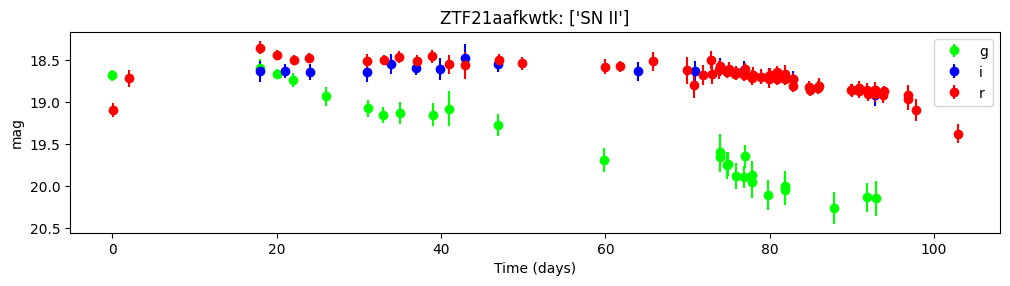

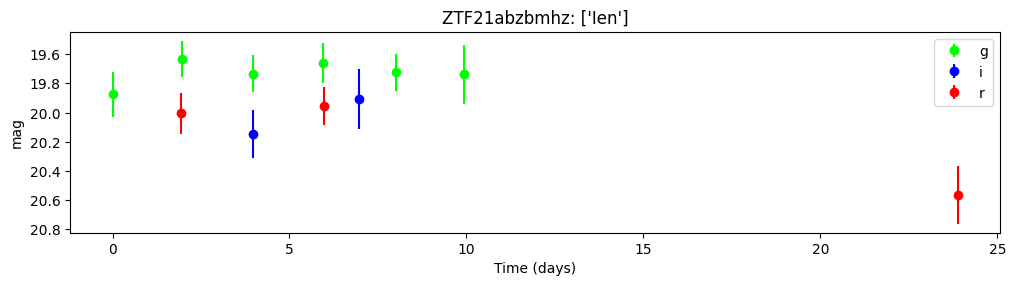

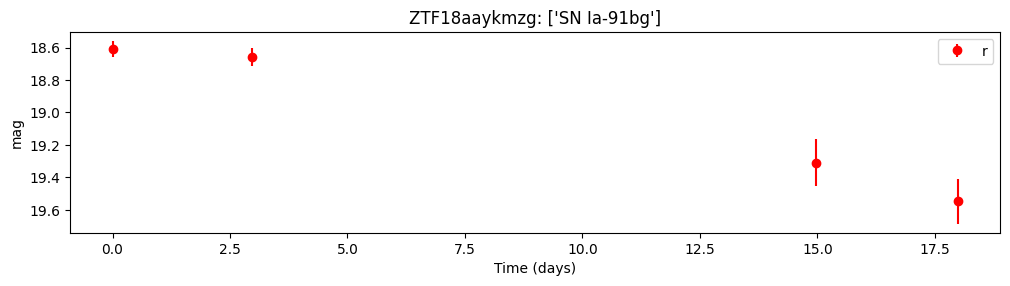

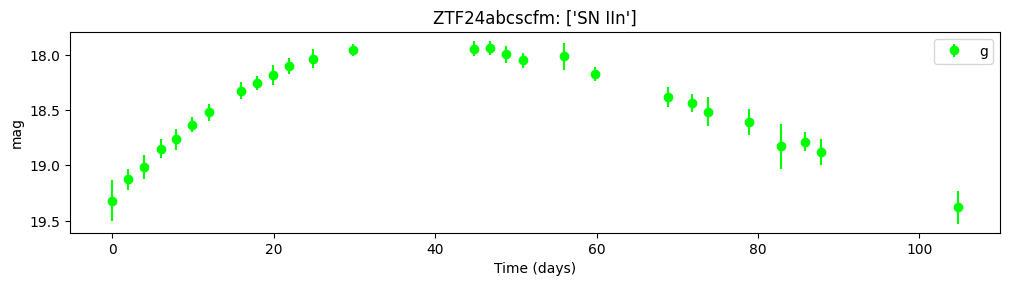

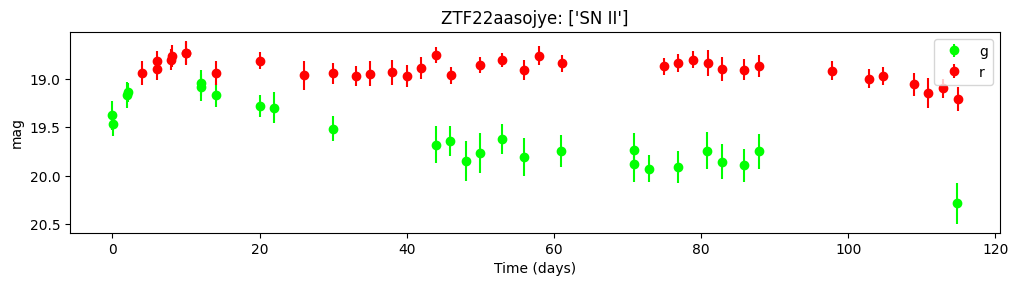

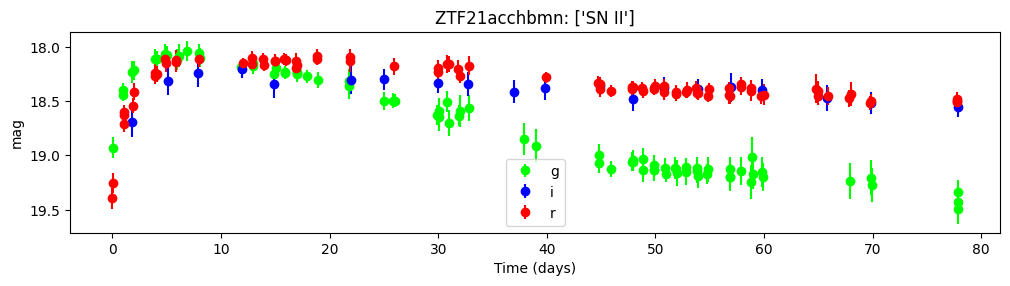

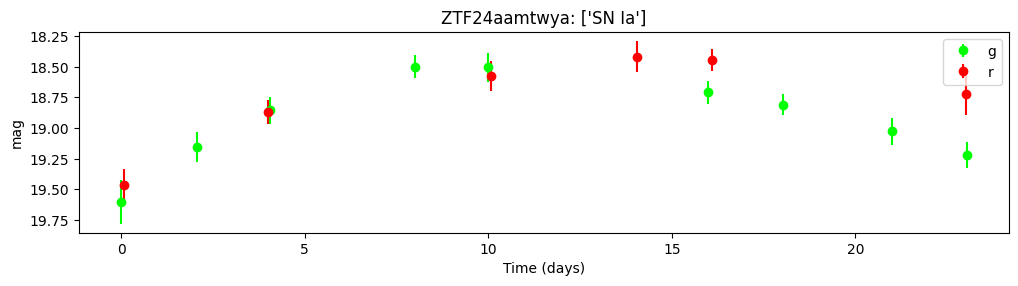

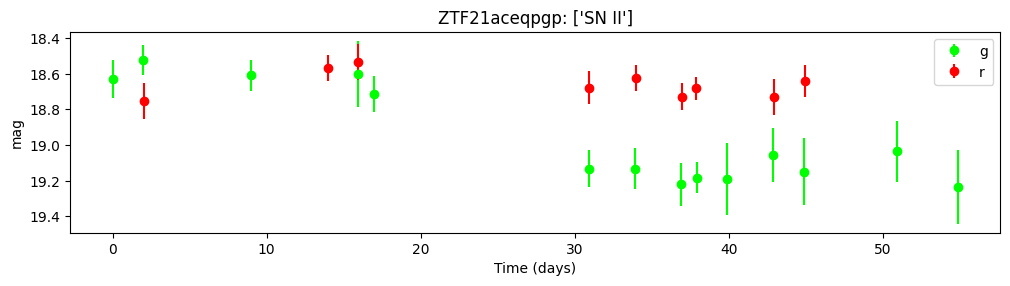

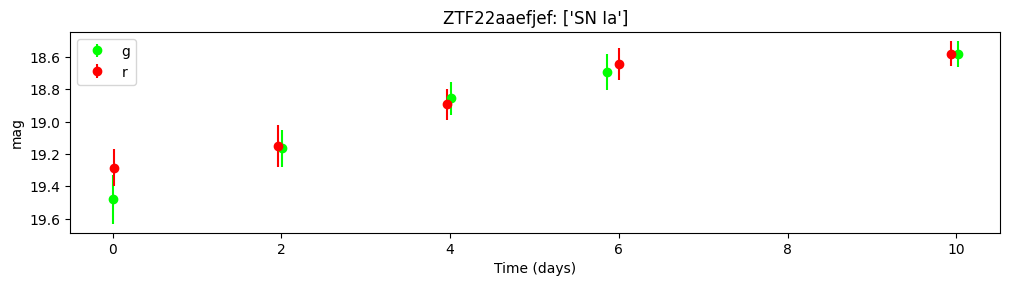

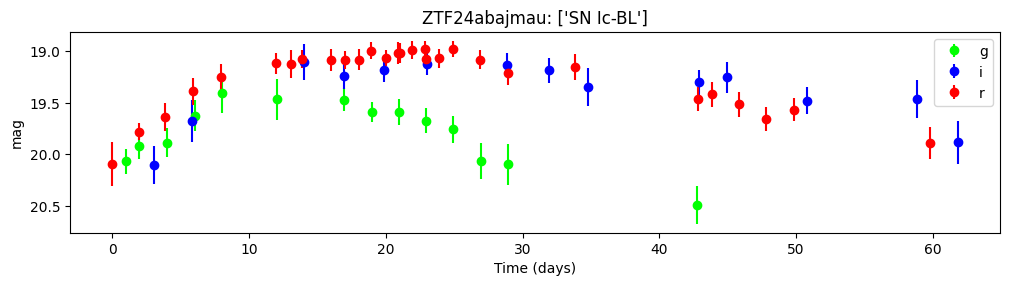

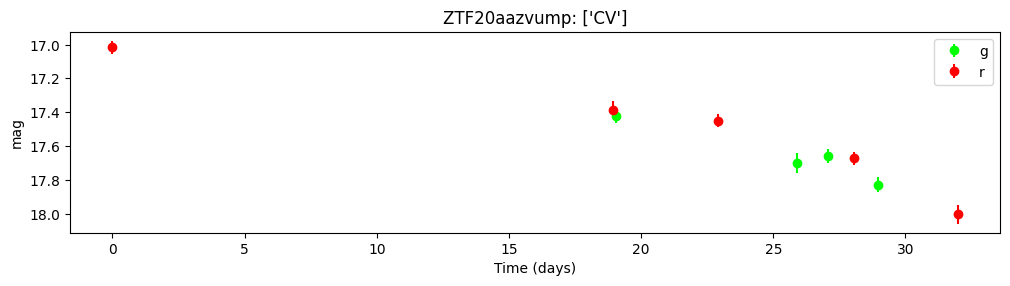

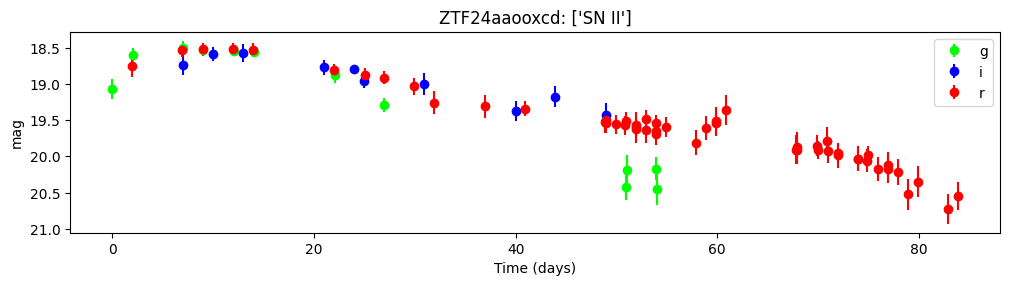

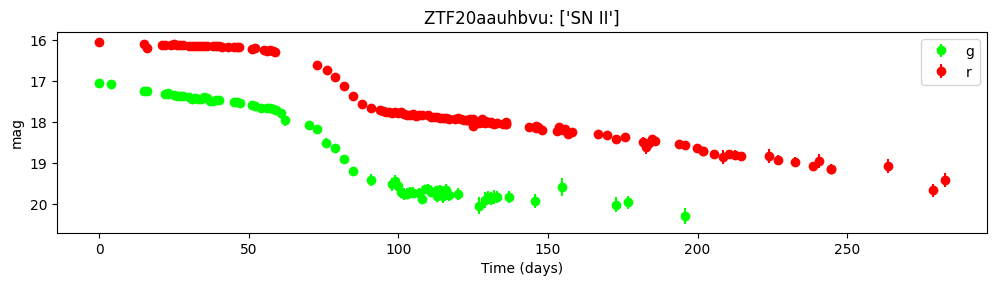

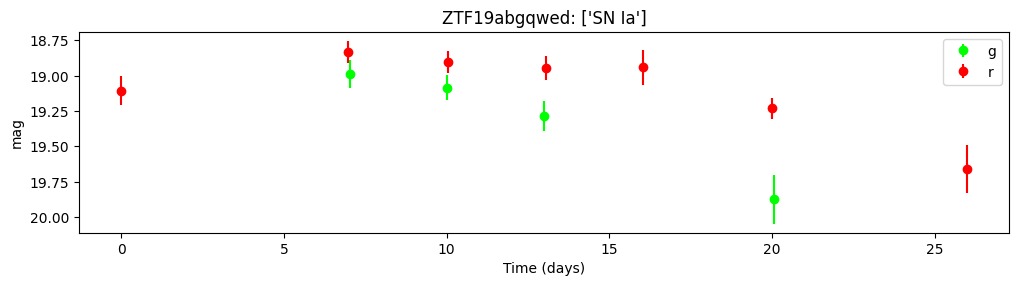

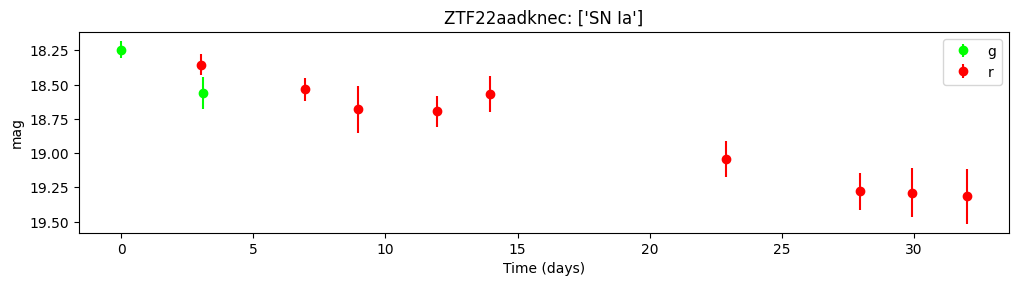

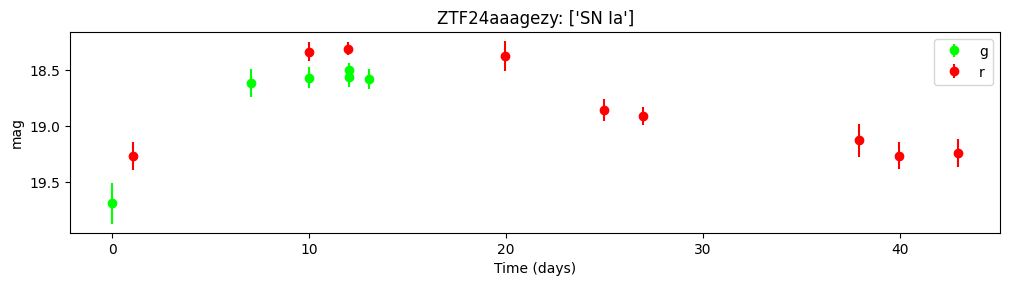

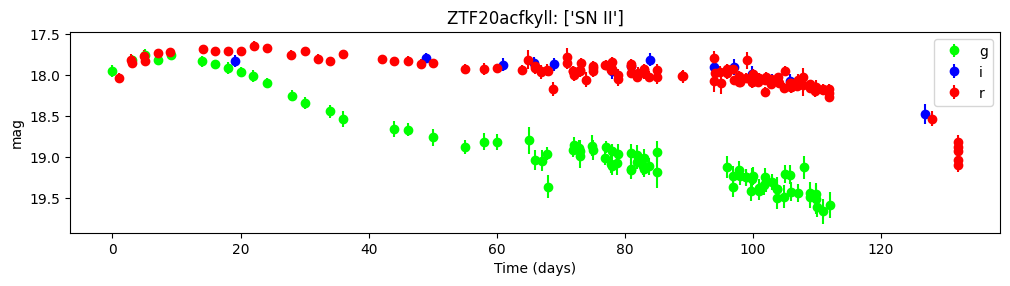

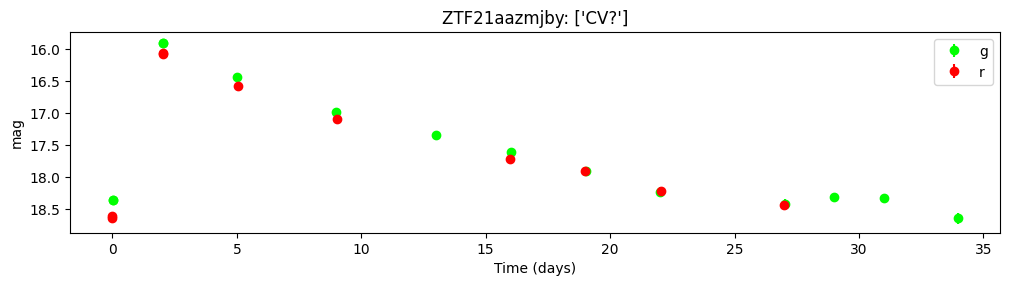

In [171]:
for i in anomalies['ztf_ids']:
    plot_ztf_data(i)
    print("========")

In [172]:
# for c in np.unique(final_embeddings['bts_class'].to_list()):
#     class_df = final_embeddings[final_embeddings['bts_class']==c]
#     print(c, np.median(class_df['a_score']))
#     #sns.kdeplot(class_df, x='a_score', label=c)
#     plt.hist(class_df['a_score'].to_list(), density=True, label=c, cumulative=True, histtype='step')
#     #plt.xlim(min(class_df['a_score'].to_list()), max(class_df['a_score'].to_list()))
#     #plt.show()
# plt.legend()
# #plt.show()